In [1]:
from google.colab import files
# Upload file
uploaded = files.upload()  # Akan muncul tombol upload

Saving IT Support Ticket Data.csv to IT Support Ticket Data.csv


In [2]:
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [3]:
!pip install transformers torch scikit-learn

# Load Dataset

In [5]:
import pandas as pd

df = pd.read_csv('IT Support Ticket Data.csv')
df.head(5)

,Unnamed: 0,Body,Department,Priority,Tags
0,0,"Dear Customer Support Team,I am writing to rep...",Technical Support,high,"['Account', 'Disruption', 'Outage', 'IT', 'Tec..."
1,1,"Dear Customer Support Team,I hope this message...",Returns and Exchanges,medium,"['Product', 'Feature', 'Tech Support']"
2,2,"Dear Customer Support Team,I hope this message...",Billing and Payments,low,"['Billing', 'Payment', 'Account', 'Documentati..."
3,3,"Dear Support Team,I hope this message reaches ...",Sales and Pre-Sales,medium,"['Product', 'Feature', 'Feedback', 'Tech Suppo..."
4,4,"Dear Customer Support,I hope this message reac...",Technical Support,high,"['Feature', 'Product', 'Documentation', 'Feedb..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29651 entries, 0 to 29650
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  29651 non-null  int64 
 1   Body        29650 non-null  object
 2   Department  29651 non-null  object
 3   Priority    29651 non-null  object
 4   Tags        29651 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [7]:
df.describe()

,Unnamed: 0
count,29651.000000
mean,14825.000000
std,8559.650752
min,0.000000
25%,7412.500000
50%,14825.000000
75%,22237.500000
max,29650.000000


In [8]:
df.isnull().sum()

,0
Unnamed: 0,0
Body,1
Department,0
Priority,0
Tags,0


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df['Body'] = df['Body'].fillna("")

In [11]:
drop_columns = [
    'Unnamed: 0',
    'Department',
    'Tags'
]

df = df.drop(columns=drop_columns)

In [12]:
df.columns

Index(['Body', 'Priority'], dtype='object')

# Encoding Label

In [13]:
TEXT_COL = "Body"
LABEL_COL = "Priority"

In [14]:
df = df.dropna(subset=[TEXT_COL, LABEL_COL])
df[TEXT_COL] = df[TEXT_COL].astype(str)

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df[LABEL_COL])

df.head()

,Body,Priority,label_encoded
0,"Dear Customer Support Team,I am writing to rep...",high,0
1,"Dear Customer Support Team,I hope this message...",medium,2
2,"Dear Customer Support Team,I hope this message...",low,1
3,"Dear Support Team,I hope this message reaches ...",medium,2
4,"Dear Customer Support,I hope this message reac...",high,0


In [17]:
import os

os.makedirs("Model_Distilbert", exist_ok=True)

In [18]:
import pickle

with open("Model_Distilbert/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ label_encoder.pkl berhasil disimpan")

✅ label_encoder.pkl berhasil disimpan


# Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df[TEXT_COL].tolist(),
    df["label_encoded"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label_encoded"]
)

# Tokenisasi DistilBERT

In [20]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128
)

# Custom Dataset Class

In [22]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [23]:
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Model DistilBERT

In [24]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_encoder.classes_)
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",          # 🔥 GANTI INI
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

/tmp/ipython-input-687929807.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.979700,0.998643


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
trainer.evaluate()

In [ ]:
model.save_pretrained("Model_Distilbert")
tokenizer.save_pretrained("Model_Distilbert")

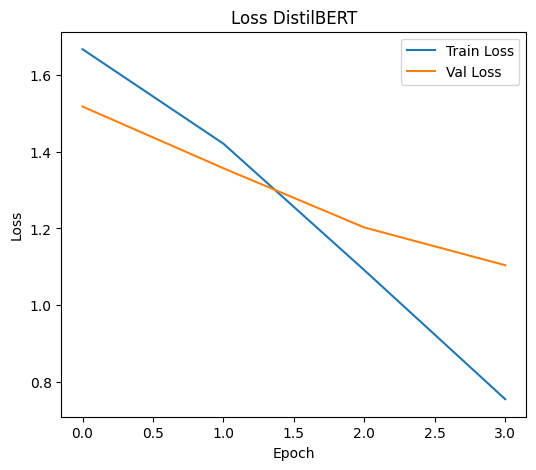

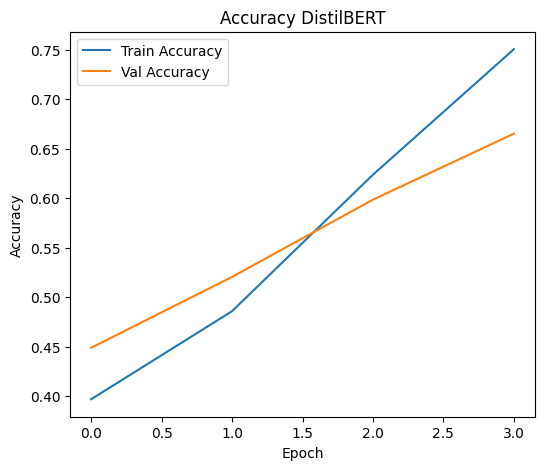

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss DistilBERT")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Accuracy DistilBERT")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluasi Model

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(
    all_labels,
    all_preds,
    target_names=label_encoder.classes_
))


                                 precision    recall  f1-score   support

           Billing and Payments       0.87      0.85      0.86       604
               Customer Service       0.50      0.69      0.58       896
                General Inquiry       0.63      0.29      0.39        84
                Human Resources       0.61      0.52      0.56       114
                     IT Support       0.68      0.52      0.59       700
                Product Support       0.61      0.65      0.63      1108
          Returns and Exchanges       0.76      0.53      0.62       293
            Sales and Pre-Sales       0.66      0.46      0.54       177
Service Outages and Maintenance       0.76      0.71      0.73       231
              Technical Support       0.73      0.72      0.73      1723

                       accuracy                           0.67      5930
                      macro avg       0.68      0.59      0.62      5930
                   weighted avg       0.68      0

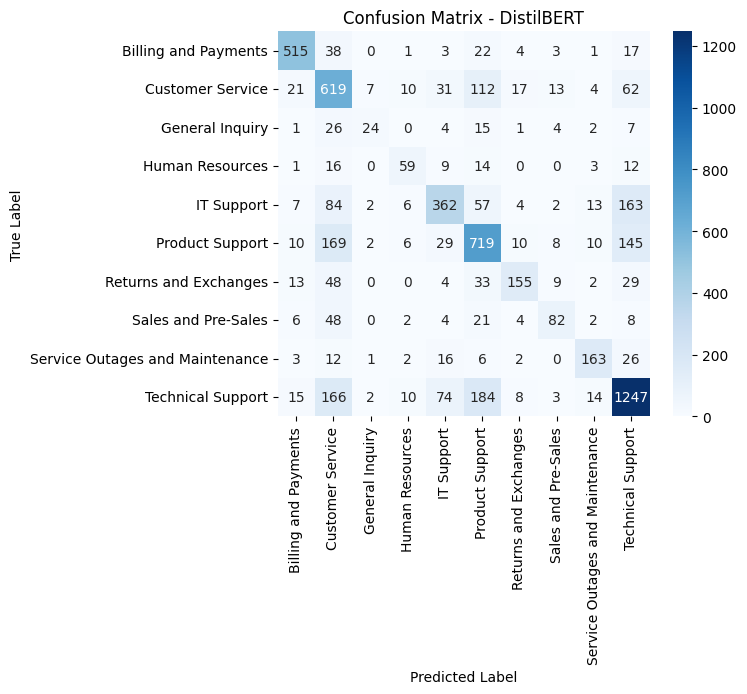

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DistilBERT")
plt.show()

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import os
os.makedirs("distilbert", exist_ok=True)

model.save_pretrained("distilbert")
tokenizer.save_pretrained("distilbert")

('distilbert/tokenizer_config.json',
 'distilbert/special_tokens_map.json',
 'distilbert/vocab.txt',
 'distilbert/added_tokens.json')

In [ ]:
import os
os.listdir("distilbert")

['special_tokens_map.json',
 'tokenizer_config.json',
 'config.json',
 'vocab.txt',
 'model.safetensors']

In [ ]:
!zip -r distilbert_model.zip distilbert

  adding: distilbert/ (stored 0%)
  adding: distilbert/special_tokens_map.json (deflated 42%)
  adding: distilbert/tokenizer_config.json (deflated 75%)
  adding: distilbert/config.json (deflated 56%)
  adding: distilbert/vocab.txt (deflated 53%)
  adding: distilbert/model.safetensors (deflated 7%)


In [ ]:
from google.colab import files
files.download("distilbert_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")

files.download("label_encoder.pkl")
